# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-14 09:00:00+09:00,50767.738281,50767.738281,50246.601562,50444.589844,0,0.0,0.0
2025-11-14 09:15:00+09:00,50429.011719,50535.320312,50368.238281,50507.320312,0,0.0,0.0
2025-11-14 09:30:00+09:00,50512.851562,50584.550781,50454.789062,50584.550781,0,0.0,0.0
2025-11-14 09:45:00+09:00,50591.691406,50594.269531,50463.179688,50578.761719,0,0.0,0.0
2025-11-14 10:00:00+09:00,50580.640625,50724.539062,50572.839844,50664.449219,0,0.0,0.0
2025-11-14 10:15:00+09:00,50661.628906,50678.550781,50496.250000,50510.730469,0,0.0,0.0
2025-11-14 10:30:00+09:00,50504.878906,50595.210938,50491.121094,50540.058594,0,0.0,0.0
2025-11-14 10:45:00+09:00,50542.019531,50548.351562,50417.949219,50427.550781,0,0.0,0.0
2025-11-14 11:00:00+09:00,50431.039062,50528.558594,50398.769531,50488.250000,0,0.0,0.0


## 前日終値の取得

In [4]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-11-07 00:00:00+09:00    50276.371094
2025-11-10 00:00:00+09:00    50911.761719
2025-11-11 00:00:00+09:00    50842.929688
2025-11-12 00:00:00+09:00    51063.308594
2025-11-13 00:00:00+09:00    51281.828125
2025-11-14 00:00:00+09:00    50376.531250
Name: Close, dtype: float64


Date
2025-11-13 00:00:00+09:00    51281.828125
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [5]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-514.09


## ローソク足チャート（小さいサイズ）

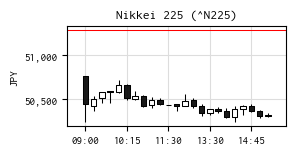

In [6]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.6))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid(color="#ddd")

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [7]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [8]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-13 09:00:00+09:00,154.701004,154.860992,154.686996,154.835999,0,0.0,0.0
2025-11-13 09:15:00+09:00,154.834000,154.878998,154.733994,154.781998,0,0.0,0.0
2025-11-13 09:30:00+09:00,154.783997,154.852005,154.725998,154.832001,0,0.0,0.0
2025-11-13 09:45:00+09:00,154.832993,154.959000,154.807999,154.942001,0,0.0,0.0
2025-11-13 10:00:00+09:00,154.936005,154.992004,154.919006,154.972000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-14 15:15:00+09:00,154.485001,154.556000,154.483994,154.550003,0,0.0,0.0
2025-11-14 15:30:00+09:00,154.550003,154.567001,154.434006,154.552994,0,0.0,0.0
2025-11-14 15:45:00+09:00,154.550003,154.660995,154.550003,154.593994,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [9]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-11-14 09:00:00+09:00,328.120163,328.120163,324.751971,326.031602
2025-11-14 09:15:00+09:00,326.198698,326.886353,325.805587,326.705235
2025-11-14 09:30:00+09:00,326.555104,327.018624,326.179742,327.018624
2025-11-14 09:45:00+09:00,327.236163,327.252838,326.404926,327.152531
2025-11-14 10:00:00+09:00,327.187967,328.118794,327.137506,327.730095
2025-11-14 10:15:00+09:00,327.928197,328.037730,326.857714,326.951445
2025-11-14 10:30:00+09:00,326.932619,327.517365,326.843561,327.160348
2025-11-14 10:45:00+09:00,327.122216,327.163198,326.319198,326.381342
2025-11-14 11:00:00+09:00,326.330020,326.961051,326.121210,326.700221


### 前日の終値のドル円レートから、前日の終値のドル換算

In [10]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-11-13 15:15:00+09:00


np.float64(154.9499969482422)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 330.95727095838294


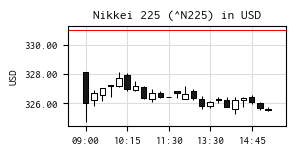

In [11]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.6))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid(color="#ddd")

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()